# data-512-homework_1 notebook for dinosaur article analysis on wikipedia
@Author: Sravan

This notebook contains the Homework 1 for DATA 512 Human Centered Data Science course at the University of Washington - Masters in Data Science program

## Step 0 - Readings
data-512-homework_1 project is an exercise with primary focus on incorporating the best practices for reproducibility and openness, as outlined in ["Assessing Reproducibility"](http://www.practicereproducibleresearch.org/core-chapters/2-assessment.html) and ["The Basic Reproducible Workflow Template"](http://www.practicereproducibleresearch.org/core-chapters/3-basic.html) from The Practice of Reproducible Research.

## Step 0 - Dependencies and Setup

Python 3.10 is used to develop this project. Python package requirements are automatically installed when you execute the cells in the jupyter notebook.
Before proceeding with the execution of project in jupyter notebook, please replace the below line
```bash
  BASE_PATH = '/Users/sravan/PycharmProjects/DATA-512-HCD/data-512-homework_1'
```

In [1]:
# Standard python modules
import os, json, time, urllib.parse

# Provide basepath of this project in your local environment
BASE_PATH = '/Users/sravan/PycharmProjects/DATA-512-HCD/data-512-homework_1'
os.chdir(BASE_PATH)
print(f'Current working directory: {os.getcwd()}')
print(f'List of files in this location')
os.listdir()

Current working directory: /Users/sravan/PycharmProjects/DATA-512-HCD/data-512-homework_1
List of files in this location


['.DS_Store',
 'LICENSE',
 'requirements.txt',
 'samp.py',
 'intermediate_files',
 'JSON_data',
 'README.md',
 'HW1_dino_page_visits_analysis.ipynb',
 '.gitignore',
 'figures',
 '.ipynb_checkpoints',
 '.git',
 'dinosaur_genera.cleaned.SEPT.2022.xlsx',
 '.idea']

In [2]:
# Installing python packages for environment setup requirements
!python -m pip install -r requirements.txt

In [3]:
# The 'requests' module to perform api requests in python
import requests

# The 'pandas' module to perform data aggregations and transformations
import pandas as pd

# The 'matplotlib.pyplot' module to control the seaborn plot display layout
from matplotlib import pyplot as plt 

## Step 1 - Datasource Information

The data for this project is extracted from the wikimedia pageviews API. The pageviews API ([documentation](https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through the previous complete month. We will make use of this API to extract the page view information of a set of [dinosaur articles](https://docs.google.com/spreadsheets/d/1zfBNKsuWOFVFTOGK8qnTr2DmHkYK4mAACBKk1sHLt_k/edit?usp=sharing)

Feel free to go through the below additional documentation
- [Pageviews API Documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews)
- [Wikimedia Foundation REST API terms of use](https://www.mediawiki.org/wiki/REST_API#Terms_and_conditions)


In [4]:
#    CONSTANTS TO FETCH THE DATA FROM WIKIMEDIA API

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': '<sravankr@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",             # this value will be set for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    # this is likely the wrong end date
}

In [5]:
# Creating a list of articles we are interested in analysing
article_df = pd.read_excel('dinosaur_genera.cleaned.SEPT.2022.xlsx')
article_df['name'].to_csv('intermediate_files/articles_list.csv')
ARTICLE_TITLES = article_df['name'].to_list()
print(f'No. of wikipedia articles considered for analysis: {len(ARTICLE_TITLES)}')

No. of wikipedia articles considered for analysis: 1423


In [6]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  access_type = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    """
    It takes an article title and an access type (desktop or mobile),
    and returns a JSON object containing the pageviews for that article
    @param article_title - the title of the article to request pageviews for
    @param access_type - the type of access to the article, either desktop or mobile
    @param endpoint_url - the URL for the API endpoint
    @param endpoint_params - the parameters for the request, which are the same for all requests
    @param request_template - this is a dictionary that contains the parameters for the request.
    @param headers - the headers for the request, which are required by the API
    @returns A JSON object with the pageviews for the article
    """
    # Make sure we have an article title
    if not article_title or not access_type: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    request_template['access'] = access_type
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    print(request_url)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

## Step 1.1 - Data Aquisition

We will be using the above mentioned wikimedia API to fetch the pageview data related to the articles listed in the above mentioned excel file. We will then dump this data in the ``` JSON_data``` folder. We will store all our data in three files one each for mobile access, desktop access, cumulative views of the articles.

We will aslo store the intermediate data in the folder ```intermediate_files```. These files contain data related to the list of articles we are processing here and the csv formatted response data to enable us manually navigate the data in a tabular format and confirm our findings. 

JSON_data/dino_monthly_desktop_201507-202209.json - JSON file containing all articles pages view data for desktop access type
JSON_data/dino_monthly_mobile_201507-202209.json - JSON file containing all articles pages view data for mobile access type
JSON_data/dino_monthly_cumulative_201507-202209.json - JSON file containing the cumulative page views of all articles for both desktop and mobile access type

### Missing data and Exception handling

It is possible that few of the articles view data is missing in cases where an article is not available for the date we are looking against. In such cases we have used a generic exception handling to let us know what is the reason of exception and the response from the request to wikimedia API.

In [7]:
def fetch_data():
    """
    It takes a list of article titles, and for each article, it requests the pageviews for that article for each of the
    three access types (mobile-app, mobile-web, desktop), and then combines the mobile-app and mobile-web pageviews into a
    single mobile pageview
    """
    mobile_response_list = []
    desktop_response_list = []
    cumu_response_list = []
    for article in ARTICLE_TITLES:
        try:
            mob_app_views = request_pageviews_per_article(article, 'mobile-app')['items']
            mob_web_views = request_pageviews_per_article(article, 'mobile-web')['items']
            desk_views = request_pageviews_per_article(article, 'desktop')['items']
            cumu_views = request_pageviews_per_article(article, 'all-access')['items']

            mob_views = []
            for app_view, web_view, desk_view, cumu_view in zip(mob_app_views, mob_web_views, desk_views, cumu_views):
                mob_view = app_view
                mob_view['views'] += web_view['views']

                del mob_view['access']
                mob_views.append(mob_view)
                del desk_view['access']
                del cumu_view['access']

            mobile_response_list += mob_views
            desktop_response_list += desk_views
            cumu_response_list += cumu_views

        except e:
            print(e)
            print(f'Data not found for: {article}')

    with open('JSON_data/dino_monthly_mobile_201507-202209.json', 'w') as f:
        json.dump(mobile_response_list, f)

    with open('JSON_data/dino_monthly_desktop_201507-202209.json', 'w') as f:
        json.dump(desktop_response_list, f)

    with open('JSON_data/dino_monthly_cumulative_201507-202209.json', 'w') as f:
        json.dump(cumu_response_list, f)

### Uncomment the below line to download a fresh copy of json files containing the article view data
# fetch_data() 

## Step 2 - Analysis and Visualization

We will be using the Pandas python library to perform different transformation in our data, starting from datetime conversions to gouping the data by article to find max/min/mean views that we will be further showcasing in the visualizations. Below are the intermediate files that we save to manually explore the data in a tabular format and validate our finding through the scripts.

intermediate_files/articles_list.csv - CSV file containing the list of article titles we process in this project
intermediate_files/dino_monthly_desktop_201507-202209.csv - CSV file containing all articles pages view data for desktop access type
intermediate_files/dino_monthly_mobile_201507-202209.csv - CSV file containing all articles pages view data for mobile access type
intermediate_files/dino_monthly_cumulative_201507-202209.csv - CSV file containing the cumulative page views of all articles for both desktop and mobile 


In [8]:
def read_json_to_df(file):
    """
    Read a JSON file into a Pandas DataFrame, convert the timestamp column to a datetime object, and return the DataFrame
    @param file - the file path to the json file
    @returns A dataframe
    """
    df = pd.read_json(file, 
                      convert_dates=False,
                      dtype={'timestamp': pd.StringDtype})
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')
    return df

mobile_df = read_json_to_df('JSON_data/dino_monthly_mobile_201507-202209.json')
desktop_df = read_json_to_df('JSON_data/dino_monthly_desktop_201507-202209.json')
cumu_df = read_json_to_df('JSON_data/dino_monthly_cumulative_201507-202209.json')

mobile_df.to_csv('intermediate_files/dino_monthly_mobile_201507-202209.csv')
desktop_df.to_csv('intermediate_files/dino_monthly_desktop_201507-202209.csv')
cumu_df.to_csv('intermediate_files/dino_monthly_cumulative_201507-202209.csv')
mobile_df.dtypes

project                object
article                object
granularity            object
timestamp      datetime64[ns]
agent                  object
views                   int64
dtype: object

### Figure showing Maximum Average and Minimum Average articles

The first visualization is a time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access. The graph has four lines (max desktop, min desktop, max mobile, min mobile).

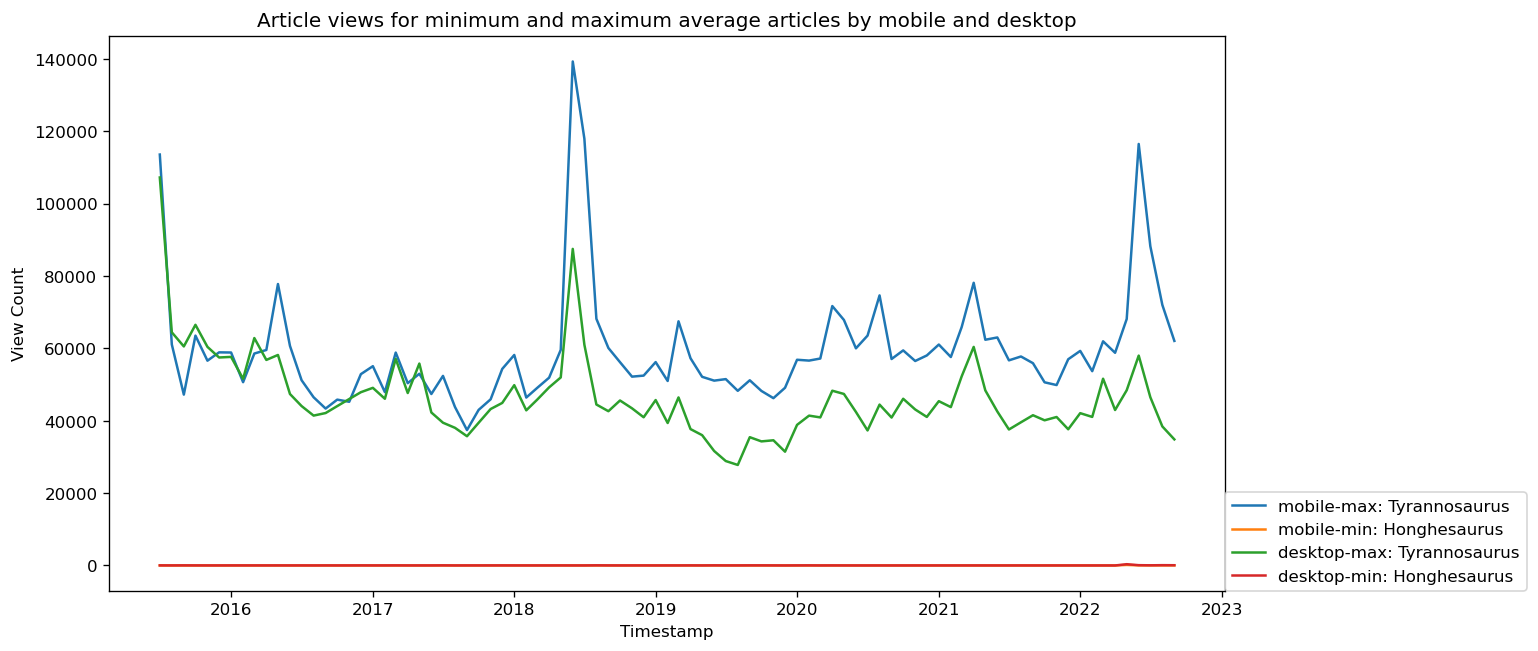

In [9]:
def get_max_min_avg_articles(df):
    """
    It takes a dataframe as input, groups the dataframe by article, then finds the mean of the views for each article. It
    then finds the index of the max and min values of the views column, and returns the rows of the dataframe that
    correspond to the max and min values.
    @param df - the dataframe
    @returns the dataframe of the article with the maximum views and the dataframe of the article with the minimum views.
    """
    df_grpd = df.groupby('article').mean('views')
    max_view_article = df_grpd.loc[df_grpd['views'].idxmax()].name
    min_view_article = df_grpd.loc[df_grpd['views'].idxmin()].name
    
    return df[df['article'] == max_view_article], df[df['article'] == min_view_article]

mob_max_df, mob_min_df = get_max_min_avg_articles(mobile_df)
desk_max_df, desk_min_df = get_max_min_avg_articles(desktop_df)

def plot_line(df, part_label):
    """
    The function takes a dataframe and a string as input, and plots the views over time for the dataframe, with the label
    of the plot being the string plus the article name
    @param df - the dataframe to plot
    @param part_label - a string that will be used to label the plot
    """
    plt.plot(df['timestamp'],df['views'], label=part_label + df.iloc[0]['article'])

plt.figure(figsize=(12, 6), dpi=120)
plot_line(mob_max_df, 'mobile-max: ')
plot_line(mob_min_df, 'mobile-min: ')
plot_line(desk_max_df, 'desktop-max: ')
plot_line(desk_min_df, 'desktop-min: ')
plt.xlabel('Timestamp')
plt.ylabel('View Count')
plt.title('Article views for minimum and maximum average articles by mobile and desktop')
plt.legend(prop={'size': 10}, loc=(1, 0))
plt.savefig('figures/min_max_viewed_articles.png')

### Figure showing Top 10 Peak Page Views

The second visualization is a time series for the top 10 article pages by largest (peak) page views over the entire time by access type. The graph has the top 10 for desktop and top 10 for mobile access (20 lines).

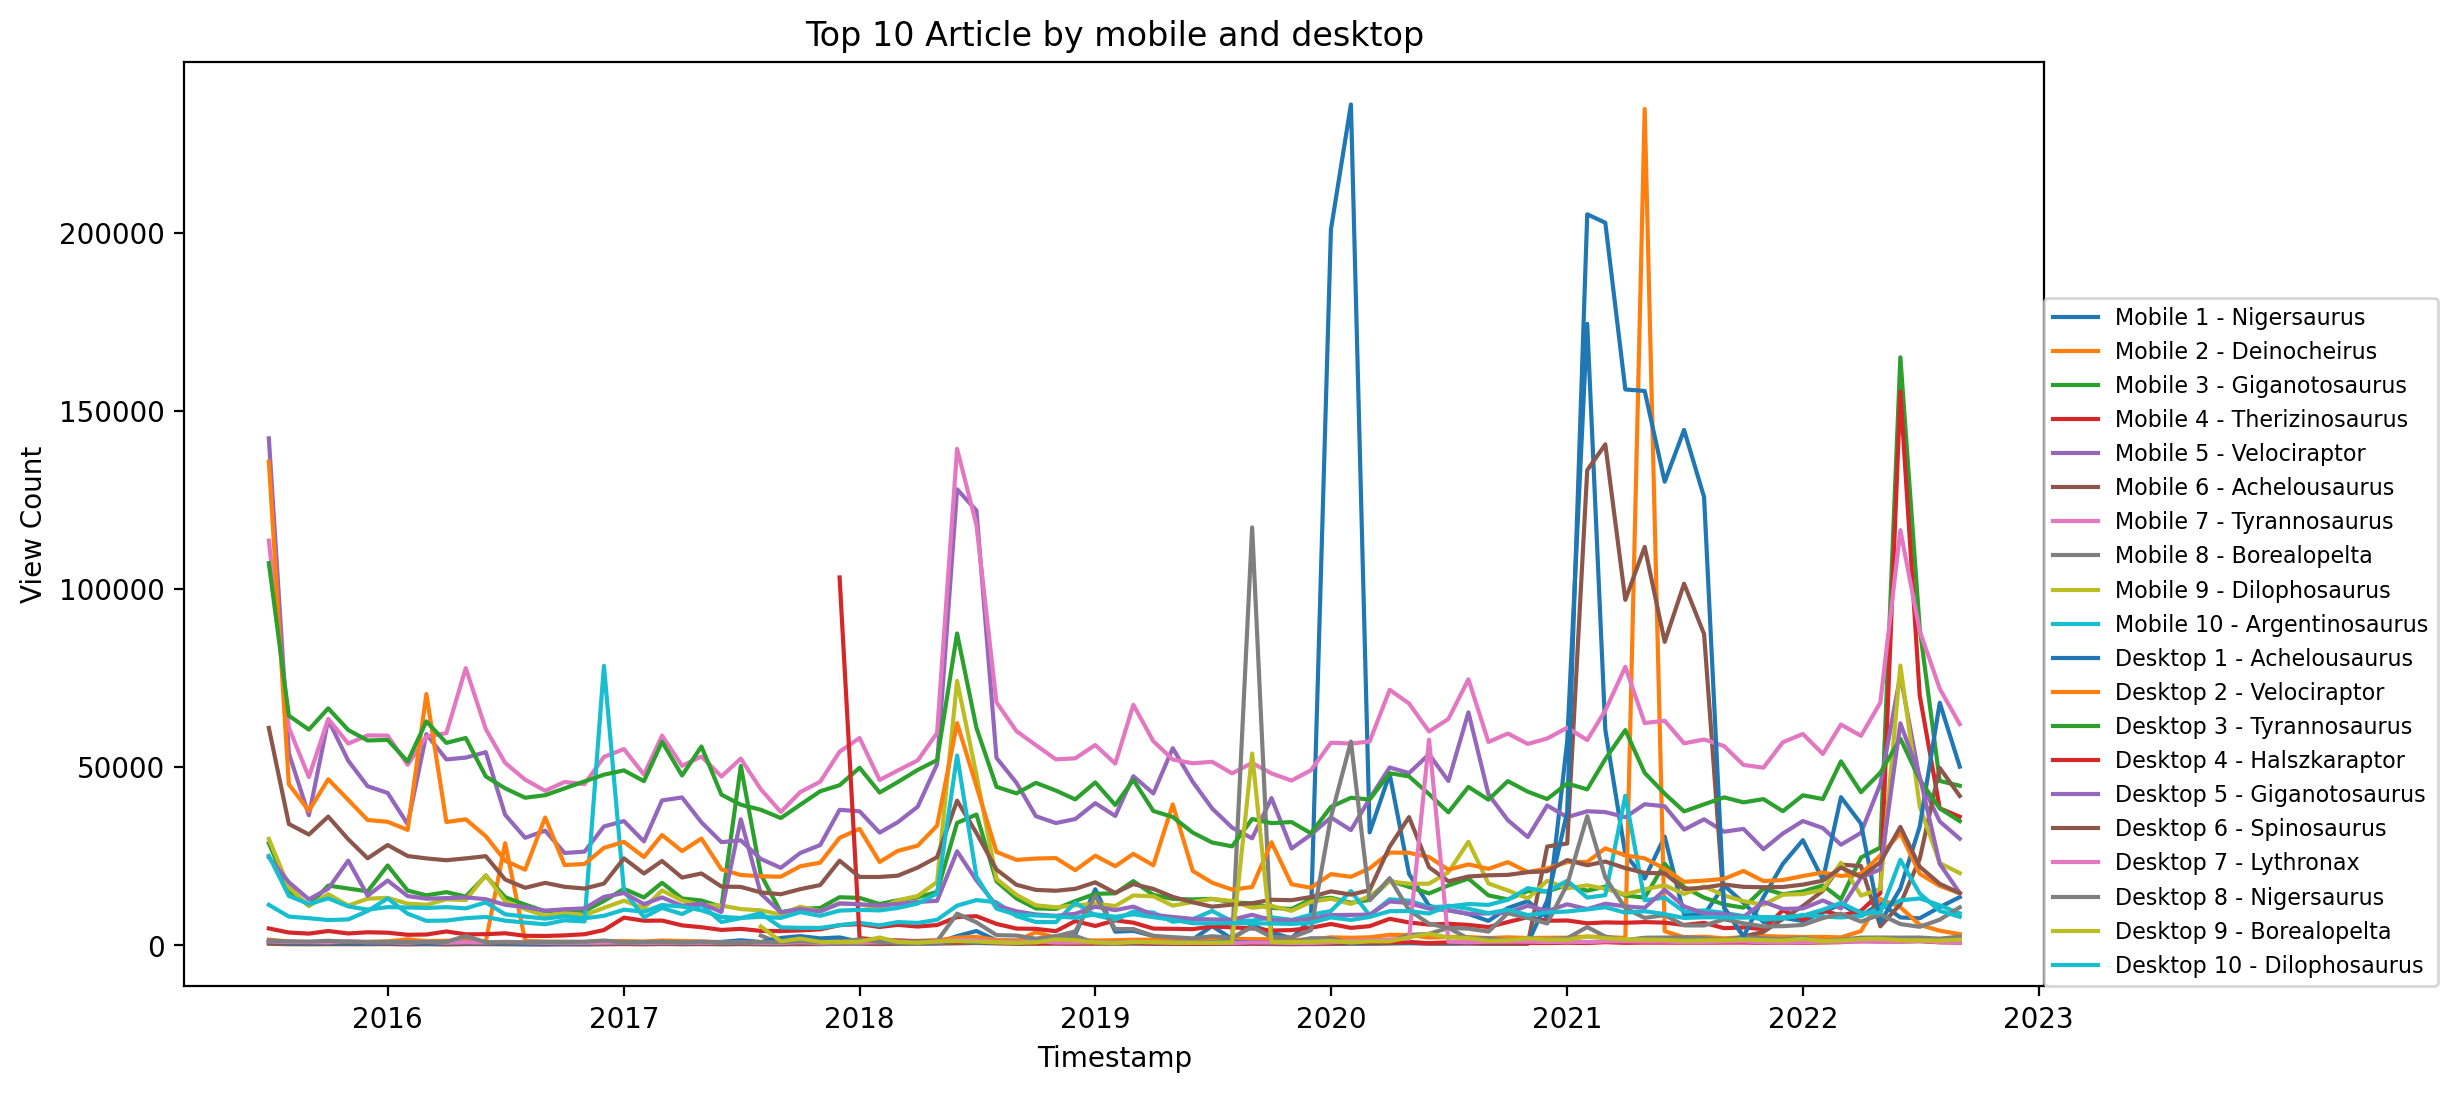

In [10]:
def get_top_10(df):
    """
    The function performs the below operations,
    1. Group the dataframe by article and get the max views for each article.
    2. Sort the dataframe by views in descending order.
    3. Get the top 10 articles.
    4. Return the top 10 articles and the dataframe with only the top 10 articles.
    @param df - the dataframe
    @returns The top 10 articles and the dataframe with only the top 10 articles
    """
    df_grpd = df.groupby(['article'], as_index=False).max('views').sort_values(by=['views'], ascending=False).iloc[:10]
    return df_grpd['article'], df[df['article'].isin(df_grpd['article'].to_list())]

mobile_top10, mobile_top10_df = get_top_10(mobile_df)
desktop_top10, desktop_top10_df = get_top_10(desktop_df)

plt.figure(figsize=(12, 6), dpi=200)
for idx, article in enumerate(mobile_top10):
    plot_line(mobile_top10_df[mobile_top10_df['article'] == article], f'Mobile {idx+1} - ')
    

for idx, article in enumerate(desktop_top10):
    plot_line(desktop_top10_df[desktop_top10_df['article'] == article], f'Desktop {idx+1} - ')

plt.xlabel('Timestamp')
plt.ylabel('View Count')
plt.title('Top 10 Article by mobile and desktop')
plt.legend(prop={'size': 8}, loc=(1, 0))
plt.savefig('figures/top_10_most_viewed_articles.png')

### Figure showing articles with fewest months of Data

The third visualization is a time series of the articles that have the fewest months of available data. The plot will have relatively short time series, some may only have one month of data. The graph has the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

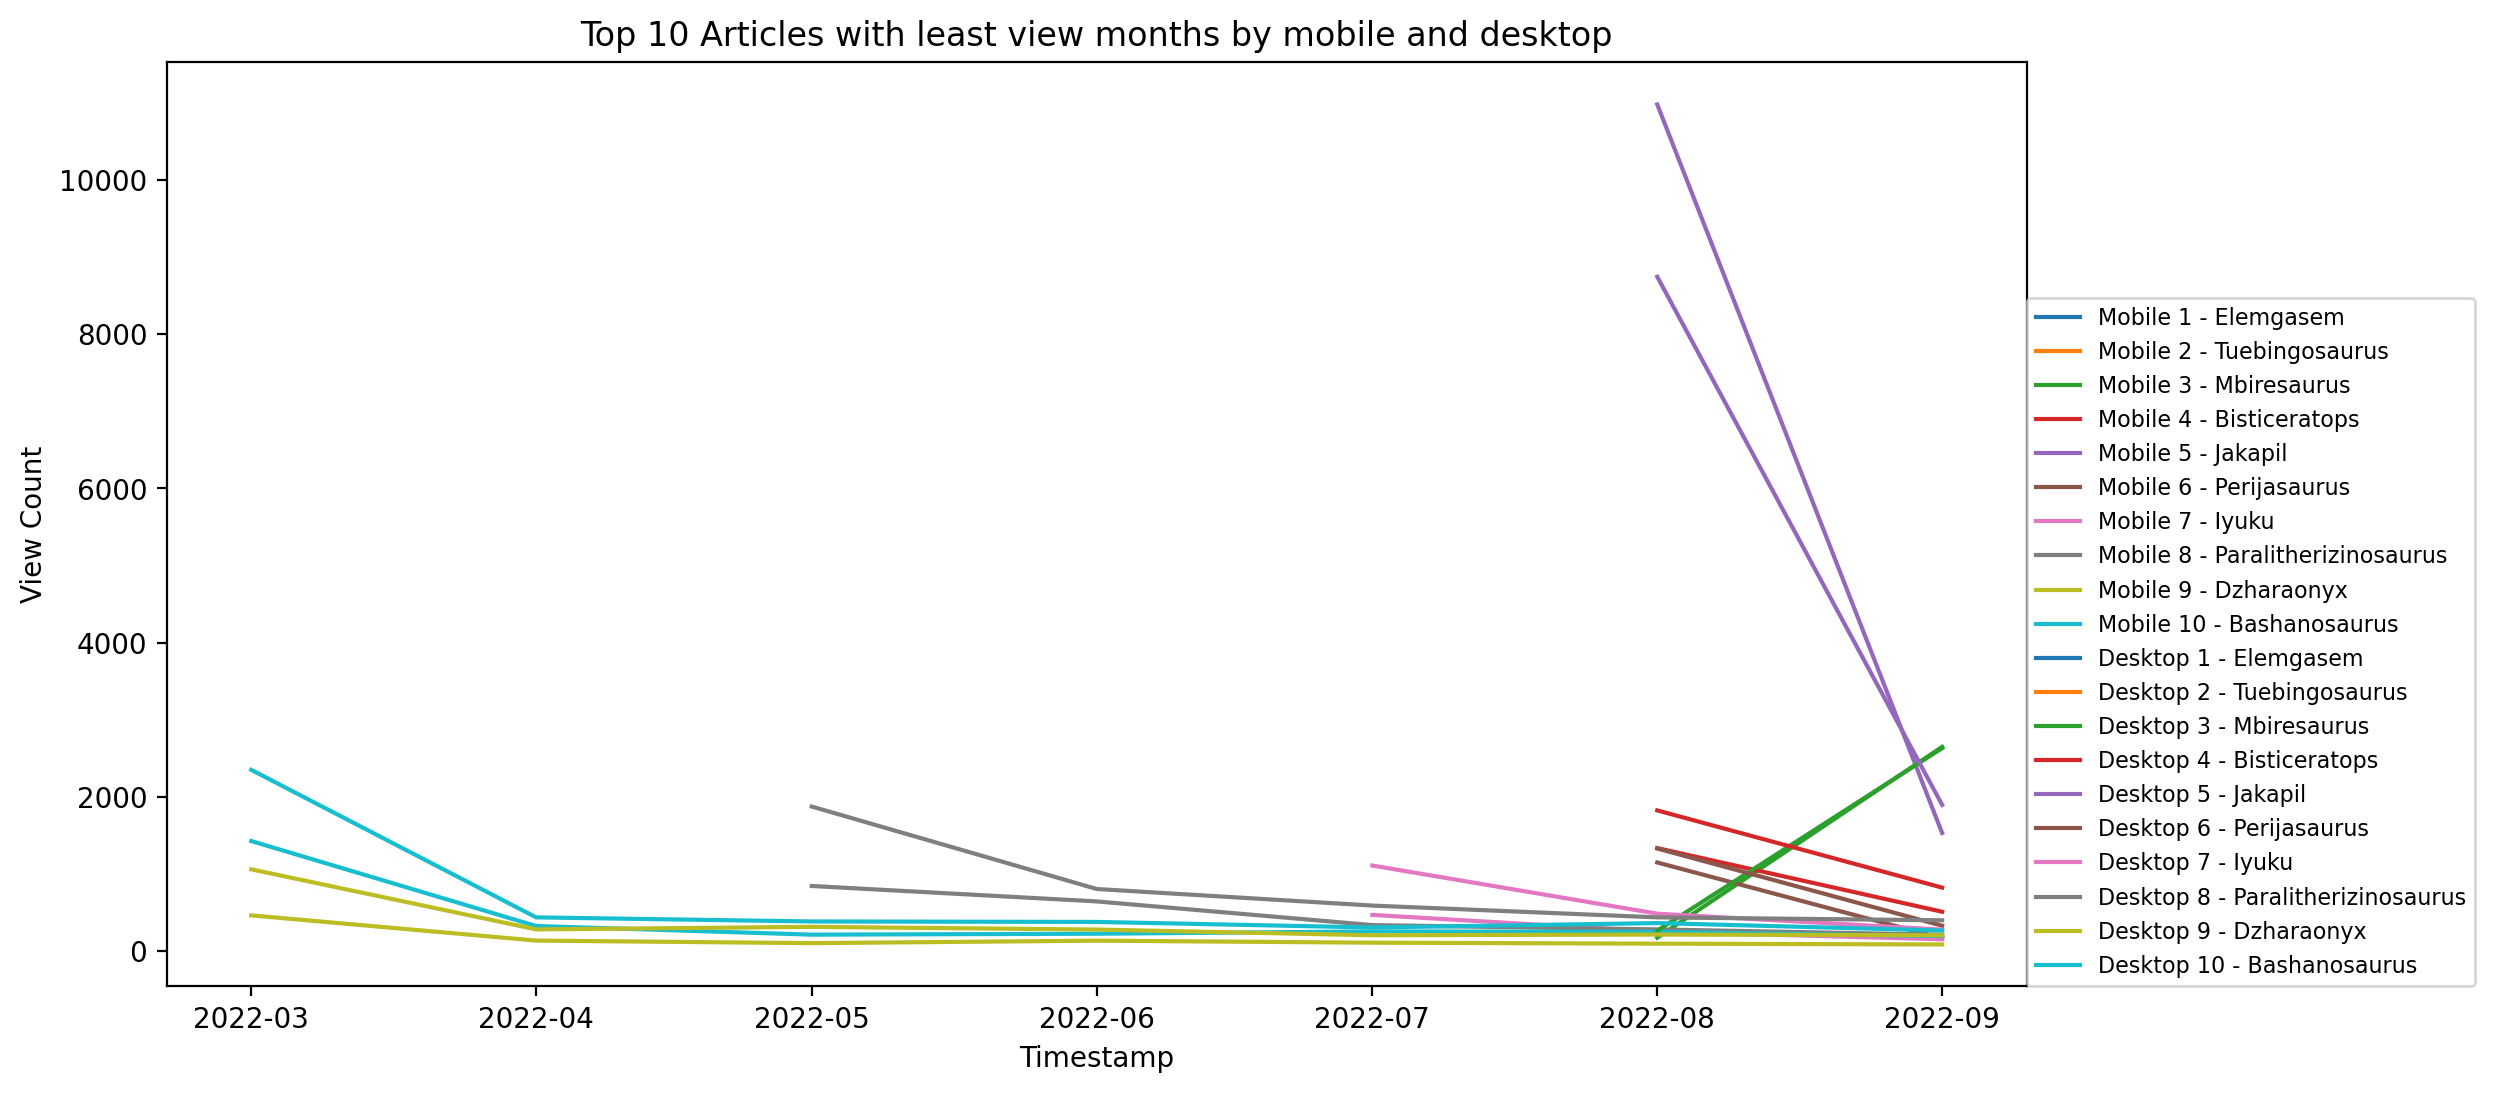

In [11]:
def articles_by_least_view_months(df):
    """
    It returns the top 10 articles that have the least number of views per month
    @param df - the dataframe
    @returns A tuple of two dataframes.
    """
    df_grpd = df[['article', 'views']]\
                .groupby(['article'], as_index=False)\
                .count()\
                .sort_values(by=['views'])\
                .iloc[:10]\
                .rename(columns={'views': 'count'})
    
    return df_grpd['article'], df[df['article'].isin(df_grpd['article'].to_list())]

mobile_least, mobile_least_df = articles_by_least_view_months(mobile_df)
desktop_least, desktop_least_df = articles_by_least_view_months(desktop_df)

plt.figure(figsize=(12, 6), dpi=200)
for idx, article in enumerate(mobile_least):
    plot_line(mobile_least_df[mobile_least_df['article'] == article], f'Mobile {idx+1} - ')
    

for idx, article in enumerate(desktop_least):
    plot_line(desktop_least_df[desktop_least_df['article'] == article], f'Desktop {idx+1} - ')

plt.xlabel('Timestamp')
plt.ylabel('View Count')
plt.title('Top 10 Articles with least view months by mobile and desktop')
plt.legend(prop={'size': 8}, loc=(1, 0))
plt.savefig('figures/least_view_month_articles.png')